# Question Answering with Langchain and Mistral

<a target="_blank" href="https://colab.research.google.com/github/elastic/elasticsearch-labs/blob/main/notebooks/generative-ai/question-answering.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 대화형 노트북은 Langchain을 사용하여 가상의 직장 문서를 구절로 분할하고 "multilingual-e5-base"를 사용하여 이러한 구절을 임베딩으로 변환하고 Elasticsearch에 저장합니다.

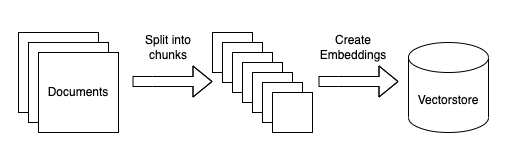

그런 다음 질문을 하면 벡터 스토어에서 관련 구절을 검색하고 langchain과 Mistral LLM을 사용하여 질문에 대한 요약을 제공합니다.

## Install packages and import modules


In [15]:
# install packages
%pip install -U langchain elasticsearch tiktoken sentence_transformers llama-cpp-python wget 

Note: you may need to restart the kernel to use updated packages.


In [16]:
# import modules
from getpass import getpass
from langchain import PromptTemplate
from langchain.vectorstores import ElasticsearchStore
from langchain.embeddings import HuggingFaceEmbeddings
from urllib.request import urlopen
from langchain.text_splitter import CharacterTextSplitter
from langchain.llms import LlamaCpp
from langchain.memory import ConversationBufferMemory
from langchain.chains import RetrievalQA, ConversationalRetrievalChain
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
import json
import os
import wget

cwd = os.getcwd()

## Connect to Elasticsearch

[ElasticsearchStore](https://api.python.langchain.com/en/latest/Vectorstores/langchain.Vectorstores.elasticsearch.ElasticsearchStore.html)를 사용하여 Elastic Cloud 배포에 연결하겠습니다. 이렇게 하면 데이터를 쉽게 생성하고 색인화하는 데 도움이 됩니다. 

ElasticsearchStore 인스턴스에서 임베딩을 [HuggingFaceEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.huggingface.HuggingFaceEmbeddings.html)로 설정하여 해당 텍스트와 Elasticsearch 인덱스 이름을 임베드합니다. 임베딩 모델은 [intfloat/multilingual-e5-base](https://huggingface.co/intfloat/multilingual-e5-base) 모델을 사용합니다.

In [17]:
# # set elastic client info
# ES_URL = input('Elasticsearch URL(ex:https://127.0.0.1:9200): ')
# ES_USER = "elastic" 
# ES_USER_PASSWORD = getpass('elastic user PW: ')
# CERT_PATH = input('Elasticsearch pem 파일 경로: ')
# # pem 생성 방법: https://cdax.ch/2022/02/20/elasticsearch-python-workshop-1-the-basics/

from getpass import getpass

ES_URL = "https://localhost:9200" #input('Elasticsearch URL(ex:https://127.0.0.1:9200): ')
ES_USER = "elastic" 
ES_USER_PASSWORD = "elastic" #getpass('elastic user PW: ')
CERT_PATH = 'D:\\es\\8.11.1\\kibana-8.11.1\\data\\ca_1701918227592.crt' #input('Elasticsearch pem 파일 경로: ')
# pem 생성 방법: https://cdax.ch/2022/02/20/elasticsearch-python-workshop-1-the-basics/

In [18]:
from elasticsearch import Elasticsearch

client = Elasticsearch(
    ES_URL,
    basic_auth=(ES_USER, ES_USER_PASSWORD),
    ca_certs=CERT_PATH
)

if client.indices.exists(index="workplace_index"):
    client.indices.delete(index="workplace_index")

In [19]:
import os
cwd = os.getcwd()

if os.path.isdir(cwd + "/models"):
    pass
else:
    os.mkdir(cwd + "/models")

In [20]:
os.chdir(cwd + "/models")

if os.path.isdir(cwd + "/models/multilingual-e5-base"):
    print('이미 모델이 존재합니다.')
else:
    os.system("git lfs install & git clone https://huggingface.co/intfloat/multilingual-e5-base")   

os.chdir(cwd)

이미 모델이 존재합니다.


In [21]:
embeddings = HuggingFaceEmbeddings(model_name=cwd + "/models/multilingual-e5-base", model_kwargs = {'device': 'cpu'} )

vector_store = ElasticsearchStore(
    es_connection = client,
    index_name="workplace_index",
    embedding=embeddings
)

## Download the dataset 

샘플 데이터 세트를 다운로드하고 문서를 역직렬화해 보겠습니다.

In [22]:
response = open(cwd + "/data/data.json")

workplace_docs = json.loads(response.read())


### Split Documents into Passages

검색 특이성(retrieval specificity)을 향상하고 최종 질문 답변 프롬프트의 컨텍스트 창 내에서 여러 구절을 제공할 수 있도록 문서를 구절로 청크할 것입니다.

여기서는 400개의 토큰이 겹치는 800개의 토큰 구절로 문서를 청크합니다.

여기서는 간단한 스플리터를 사용하고 있지만 Langchain은 컨텍스트 손실 가능성을 줄이기 위해 고급 스플리터를 제공합니다.

In [23]:
metadata = []
content = []

for doc in workplace_docs:
  content.append(doc["content"])
  metadata.append({
      "name": doc["name"],
      "summary": doc["summary"]
  })

text_splitter = CharacterTextSplitter(chunk_size=800, chunk_overlap=400)
docs = text_splitter.create_documents(content, metadatas=metadata)

Created a chunk of size 866, which is longer than the specified 800
Created a chunk of size 1120, which is longer than the specified 800


## Index data into elasticsearch

이제 각 문서를 800개의 청크 크기로 분할했으므로 이제 [ElasticsearchStore.from_documents](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.elasticsearch.ElasticsearchStore.html#langchain.vectorstores.elasticsearch.ElasticsearchStore.from_documents)를 사용하여 Elasticsearch에 데이터를 인덱싱하겠습니다.

In [24]:
documents = vector_store.from_documents(
    docs, 
    embeddings, 
    es_connection=client, 
    index_name="workplace_index",
)

## Asking a question

이제 Elasticsearch에 구절이 저장되었으므로 관련 구절을 얻기 위해 질문을 할 수 있습니다.

In [25]:
import wget

if os.path.isfile(cwd + "/models/openbuddy-mistral-7b-v13.1.Q4_K_M.gguf"):
    pass
else:
    wget.download(
        # "https://huggingface.co/TheBloke/openbuddy-mistral-7B-v13.1-GGUF/resolve/main/openbuddy-mistral-7b-v13.1.Q3_K_M.gguf",
        "https://huggingface.co/TheBloke/openbuddy-mistral-7B-v13.1-GGUF/resolve/main/openbuddy-mistral-7b-v13.1.Q4_K_M.gguf",
        out=cwd + "/models/openbuddy-mistral-7b-v13.1.Q4_K_M.gguf"
    )

In [31]:
retriever = vector_store.as_retriever()

n_gpu_layers = None  # Metal set to 1 is enough.
n_batch = 52  # Should be between 1 and n_ctx, consider the amount of RAM of your Apple Silicon Chip.
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

from langchain.llms import HuggingFaceTextGenInference

# Make sure the model path is correct for your system!
llm = LlamaCpp(
    # https://huggingface.co/TheBloke/openbuddy-mistral-7B-v13-GGUF
    model_path = cwd + "/models/openbuddy-mistral-7b-v13.1.Q4_K_M.gguf",
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    n_ctx=2048,

    # https://www.reddit.com/r/LocalLLaMA/comments/1343bgz/what_model_parameters_is_everyone_using/
    temperature=0.001,
    top_k=1,
    top_p=0,

    max_tokens=1024,
    verbose=True,
    f16_kv=True,  # MUST set to True, otherwise you will run into problem after a couple of calls
    callback_manager=callback_manager,
    repeat_penalty=1.1
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 0 | VSX = 0 | 


In [32]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

In [33]:
ans = qa("What does NASA stand for?")

print("---- Answer ----")
print(ans["result"])
print("---- Sources ----")
for doc in ans["source_documents"]:
  print(doc.metadata["name"])
  print(doc.page_content)

 NASA stands for North America South America region (NASA) in the context of your company's sales organization. It is not related to the space agency with the same acronym. In your company, NASA refers to the Area Vice-Presidents Laura Martinez and Gary Johnson who oversee the North America and South America regions respectively.---- Answer ----
 NASA stands for North America South America region (NASA) in the context of your company's sales organization. It is not related to the space agency with the same acronym. In your company, NASA refers to the Area Vice-Presidents Laura Martinez and Gary Johnson who oversee the North America and South America regions respectively.
---- Sources ----
Sales Organization Overview
Our sales organization is structured to effectively serve our customers and achieve our business objectives across multiple regions. The organization is divided into the following main regions:

The Americas: This region includes the United States, Canada, Mexico, as well a

In [34]:
ans = qa("NASA는 무엇인가요? 한국어로 알려주세요")

print("---- Answer ----")
print(ans["result"])
print("---- Sources ----")
for doc in ans["source_documents"]:
  print(doc.metadata["name"])
  print(doc.page_content)

Llama.generate: prefix-match hit


 NASA는 북아메리카 남부 아메리카(NASA)라고 불립니다. 이 단체는 미국의 연방정부에서 운영되며, 우주탐사와 관련된 과학적 연구를 수행합니다.

추가 설명: NASA는 1958년에 설립되었으며, 미국의 연방정부에서 운영됩니다. 이 단체는 우주탐사와 관련된 과학적 연구를 수행하고, 우주탐사 및 우주비행과 관련된 기술을 개발합니다. NASA는 또한 미국의 외교정부와 협력하여 우주탐사를 통해 국제적인 이해와 협력을 증진시키고 있습니다.

NASA는 북아메리카 남부 아메리카(NASA)라고 불립니다. 이 단체는 미국의 연방정부에서 운영되며, 우주탐사와 관련된 과학적 연구를 수행합니다.

추가 설명: NASA는 1958년에 설립되었으며, 미국의 연방정부에서 운영됩니다. 이 단체는 우주탐사와 관련된 과학적 연구를 수행하고, 우주탐사 및 우주비행과 관련된 기술을 개발합니다. NASA는 또한 미국의 외교정부와 협력하여 우주탐사를 통해 국제적인 이해와 협력을 증진시키고 있습니다.

NASA는 북아메리카 남부 아메리카(NASA)라고 불립니다. 이 단체는 미국의 연방정부에서 운영되며, 우주탐사와 관련된 과학적 연구를 수행합니다.

추가 설명: NASA는 1958년에 설립되었으며, 미국의 연방정부에서 운영됩니다. 이 단체는 우주탐사와 관련된 과학적 연구를 수행하고, 우주탐사 및 우주비행과 관련된 기술을 개발합니다. NASA는 또한 미국의 외교정부와 협력하여 우주탐사를 통해 국제적인 이해와 협력을 증진시키고 있습니다.

NASA는 북아메리카 남부 아메리카(NASA)라고 불립니다. 이 단체는 미국의 연방정부에서 운영되며, 우주탐사와 관련된 과학적 연구를 수행합니다.

추가 설명: NASA는 1958년에 설립되었으며, 미국의 연방정부에서 운영됩니다. 이 단체는 우주탐사와 관련된 과학적 연구를 수행하고, 우주탐사 및 우주비행과 관련된 기술을 개발합니다. NASA는 또한 미국의 외교정부와 협력하여 우주탐사를 통해 국제적인 이해와 협력을 증진시키고 있습니다.

NASA는 북아메리카 남부 